# DDLS 2025 — Enhanced Diabetes Multi-Task Learning (Memory Optimized)

**Author:** Argyrios Kerezis (2025) — Memory-Optimized Version  
**⚡ Optimized for Free Google Colab (12GB RAM)**

## Enhancements:
✅ Cross-validation  
✅ Hyperparameter tuning (reduced trials)  
✅ SHAP analysis (optimized samples)  
✅ Feature importance  
✅ Calibration analysis  
✅ Attention visualization  

## Memory Optimizations:
🔧 Reduced SHAP samples (100 instead of 1000)  
🔧 Smaller batch sizes (512 instead of 1024)  
🔧 Fewer Optuna trials (10 instead of 20)  
🔧 Garbage collection between steps  
🔧 Efficient data handling  


## 0. Memory Check

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

In [ ]:
# Check available resources
import psutil
import torch

ram_gb = psutil.virtual_memory().total / 1e9
print(f"Total RAM: {ram_gb:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1e9:.1f} GB")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Total RAM: 13.6 GB
Available RAM: 7.2 GB
GPU Available: False


## 1. Install Dependencies

In [ ]:
%pip install -q ucimlrepo imbalanced-learn xgboost torch torchvision torchaudio \
    scikit-learn pandas numpy matplotlib seaborn tqdm shap optuna

## 2. Imports and Setup

In [ ]:
import os, json, warnings, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    mean_absolute_error, r2_score, roc_curve, precision_recall_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

# XGBoost
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# SHAP
import shap

# Optuna
import optuna
from optuna.pruners import MedianPruner

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)  # Smaller plots

# Memory optimization
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

print("✅ Setup complete")

Using device: cpu
✅ Setup complete


## 3. Data Loading and Feature Engineering

Fetching dataset...
Raw shape: (101766, 48)
EXPLORATION : DATA QUALITY AND COMPLETENESS
--------------------------------------------------------------------------------

 Missing Values Summary:
           Column  Missing_Count  Missing_Percentage Data_Type
           weight          98569           96.858479    object
    max_glu_serum          96420           94.746772    object
        A1Cresult          84748           83.277322    object
medical_specialty          49949           49.082208    object
       payer_code          40256           39.557416    object
             race           2273            2.233555    object
           diag_3           1423            1.398306    object
           diag_2            358            0.351787    object
           diag_1             21            0.020636    object

📈 Overall Missingness:
   Total cells: 4,884,768
   Missing cells: 374,017
   Percentage: 7.66%


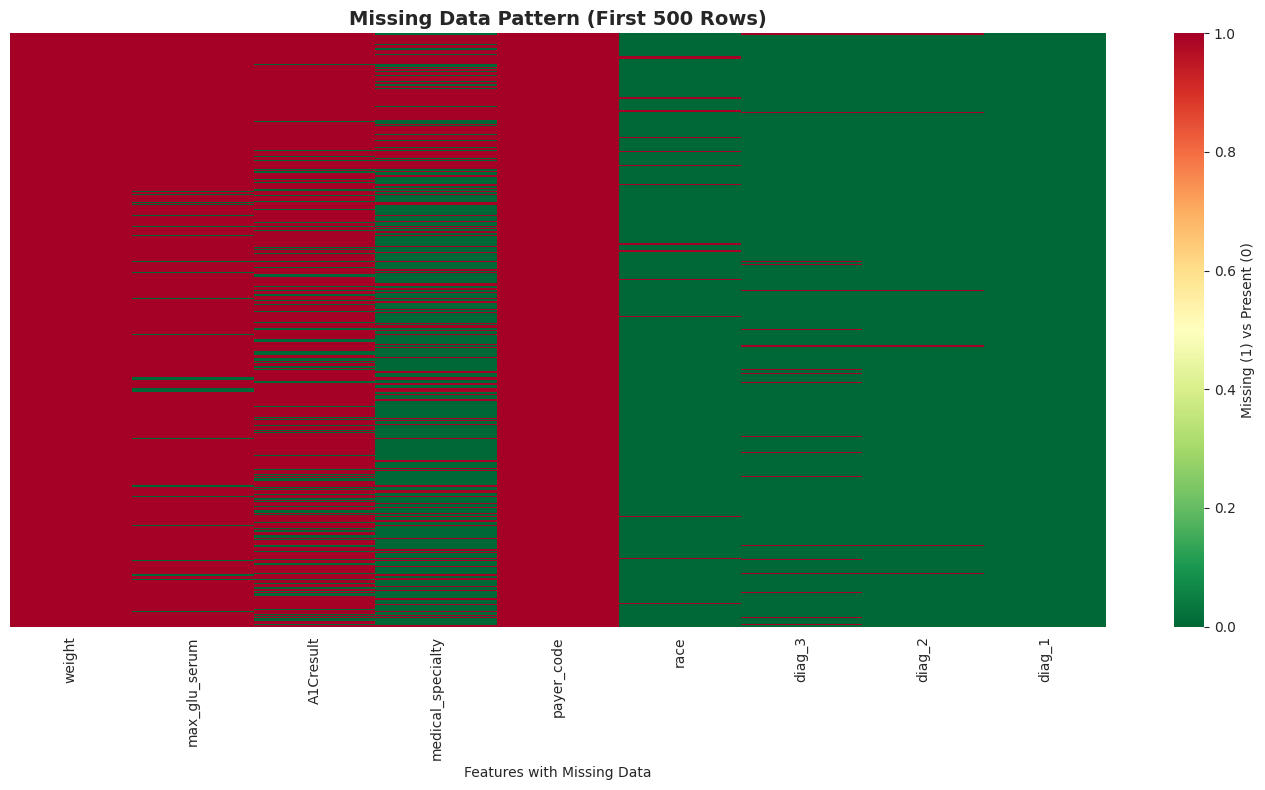


✓ Saved: missing_data_heatmap.png


In [ ]:
from ucimlrepo import fetch_ucirepo

print("Fetching dataset...")
diabetes = fetch_ucirepo(id=296)
df = pd.concat([diabetes.data.features, diabetes.data.targets], axis=1)
print(f"Raw shape: {df.shape}")



# Basic cleaning
df = df.replace("?", np.nan)

print("EXPLORATION : DATA QUALITY AND COMPLETENESS")
print("-"*80)
# ----------------------------------------------------------------------------
# Calculate missing values
# ----------------------------------------------------------------------------
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
}).sort_values('Missing_Percentage', ascending=False)

print("\n Missing Values Summary:")
missing_present = missing_stats[missing_stats['Missing_Percentage'] > 0]
if len(missing_present) > 0:
    print(missing_present.to_string(index=False))
else:
    print("   No missing values found!")

total_cells = df.shape[0] * df.shape[1]
total_missing = df.isnull().sum().sum()
print(f"\n📈 Overall Missingness:")
print(f"   Total cells: {total_cells:,}")
print(f"   Missing cells: {total_missing:,}")
print(f"   Percentage: {total_missing/total_cells*100:.2f}%")
if len(missing_present) > 0:
    plt.figure(figsize=(14, 8))

    # Select top columns with missing data for visualization
    top_missing = missing_present.head(9)['Column'].tolist()

    if len(top_missing) > 0:
        # Create binary matrix: 1 = missing, 0 = present
        missing_matrix = df[top_missing].isnull().astype(int)

        # Plot heatmap for first 500 rows
        sns.heatmap(missing_matrix.head(500),
                    cbar=True,
                    yticklabels=False,
                    cmap='RdYlGn_r',
                    cbar_kws={'label': 'Missing (1) vs Present (0)'})
        plt.title('Missing Data Pattern (First 500 Rows)',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Features with Missing Data')
        plt.tight_layout()
        plt.savefig('missing_data_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n✓ Saved: missing_data_heatmap.png")



In [ ]:
print(" Dataset loaded successfully!\n")
print(f" Dataset Information:")
print(f"   Total encounters: {len(df):,}")
print(f"   Features: {df.shape[1]} columns")
print(f"   Target column: '{df.columns[-1]}'")
print(f"   Shape: {df.shape} (rows, columns)")


 Dataset loaded successfully!

 Dataset Information:
   Total encounters: 101,766
   Features: 48 columns
   Target column: 'readmitted'
   Shape: (101766, 48) (rows, columns)


In [ ]:
# Show metadata
print(f"\n Dataset Metadata:")
metadata = diabetes.metadata
print(f"   Repository: {metadata['repository_url']}")
print(f"   DOI: {metadata['dataset_doi']}")
print(f"   Year: {metadata['year_of_dataset_creation']}")
print(f"   Instances: {metadata['num_instances']:,}")
print(f"   Features: {metadata['num_features']}")
print(f"   Abstract : {metadata['abstract']}")


 Dataset Metadata:
   Repository: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008
   DOI: 10.24432/C5230J
   Year: 2014
   Instances: 101,766
   Features: 47
   Abstract : The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.
The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing cos

In [ ]:
df = df.drop(columns=[c for c in ["encounter_id","patient_nbr","weight","payer_code",
                                    "medical_specialty","examide","citoglipton"]
                      if c in df.columns])
df["race"].fillna(df["race"].mode()[0], inplace=True)
df["readmitted"] = (df["readmitted"] == "<30").astype(int)

# Targets
y_readmit = df["readmitted"].astype(int)
y_los = df["time_in_hospital"].astype(float)

print(f"Readmission rate: {y_readmit.mean():.2%}")
print(f"Avg LOS: {y_los.mean():.2f} days")

# Free memory
del diabetes
gc.collect()

Readmission rate: 11.16%
Avg LOS: 4.40 days


4597

In [ ]:
# Clinical Risk Indices (optimized)
def charlson(row):
    score = 0
    for c in ["diag_1", "diag_2", "diag_3"]:
        v = str(row[c]) if c in row and pd.notna(row[c]) else ""
        if v.startswith("250"): score += 1
        if v.startswith(("410","411","412","413","414")): score += 1
        if v.startswith("428"): score += 1
        if v.startswith(("582","583","585","586")): score += 2
        if v.startswith(("490","491","492","493","494","495","496")): score += 1
    return min(score, 10)

def lace(row):
    los = row.get("time_in_hospital", 0.0)
    L = 7 if los >= 14 else min(int(los), 7)
    A = 3 if row.get("admission_type_id", 3) in [1, 2] else 0
    C = (5 if row["Charlson_Index"] >= 4 else 3 if row["Charlson_Index"] == 3 else
         2 if row["Charlson_Index"] == 2 else 1 if row["Charlson_Index"] == 1 else 0)
    E = 4 if row.get("number_emergency", 0) >= 4 else int(row.get("number_emergency", 0))
    return L + A + C + E

def hospital_score(row):
    s = 0
    if row.get("num_procedures", 0) > 0: s += 1
    if row.get("admission_type_id", 3) in [1, 2]: s += 1
    n_inp = row.get("number_inpatient", 0)
    if n_inp >= 5: s += 5
    elif n_inp >= 2: s += 2
    if row.get("time_in_hospital", 0) >= 5: s += 2
    return s

df["Charlson_Index"] = df.apply(charlson, axis=1)
df["LACE_Index"] = df.apply(lace, axis=1)
df["HOSPITAL_Score"] = df.apply(hospital_score, axis=1)
df["Days_Since_Last_Discharge"] = df["number_inpatient"].apply(
    lambda n: 365 if n == 0 else int(365 / (n + 1))
)
df["Polypharmacy_Count"] = df["num_medications"]
df["Recent_Hosp_Count"] = df["number_inpatient"]

print("✅ Feature engineering complete")

✅ Feature engineering complete


In [ ]:
# Prepare features
X = df.drop(columns=["readmitted", "time_in_hospital"])
yR = y_readmit.copy()
yL = y_los.copy()

# One-hot encoding (memory efficient)
X_enc = pd.get_dummies(X, drop_first=True, sparse=False)
feature_names = X_enc.columns.tolist()
print(f"Encoded features: {len(feature_names)}")

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)

# Splits
X_train, X_temp, yR_train, yR_temp, yL_train, yL_temp = train_test_split(
    X_scaled, yR, yL, test_size=0.3, stratify=yR, random_state=42
)
X_val, X_test, yR_val, yR_test, yL_val, yL_test = train_test_split(
    X_temp, yR_temp, yL_temp, test_size=0.5, stratify=yR_temp, random_state=42
)

print(f"Train: {X_train.shape[0]:,} | Val: {X_val.shape[0]:,} | Test: {X_test.shape[0]:,}")



Encoded features: 2335
Train: 71,236 | Val: 15,265 | Test: 15,265


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 120

print("="*80)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*80)


📊 EXPLORATORY DATA ANALYSIS


In [ ]:
# ============================================================================
# 1. DATASET OVERVIEW
# ============================================================================
print("\n" + "="*80)
print("1. DATASET OVERVIEW")
print("="*80)

print(f"\n📋 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\n📊 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n🔍 First Few Rows:")
print(df.head())

print("\n📈 Data Types Distribution:")
print(df.dtypes.value_counts())

print("\n📊 Basic Statistics:")
print(df.describe().T)



1. DATASET OVERVIEW

📋 Dataset Shape: 101,766 rows × 49 columns

📊 Memory Usage: 166.47 MB

🔍 First Few Rows:
              race  gender      age  admission_type_id  \
0        Caucasian  Female   [0-10)                  6   
1        Caucasian  Female  [10-20)                  1   
2  AfricanAmerican  Female  [20-30)                  1   
3        Caucasian    Male  [30-40)                  1   
4        Caucasian    Male  [40-50)                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        25                    1                 1   
1                         1                    7                 3   
2                         1                    7                 2   
3                         1                    7                 2   
4                         1                    7                 1   

   num_lab_procedures  num_procedures  num_medications  ...  \
0                  41               0                1  


2. TARGET VARIABLE ANALYSIS


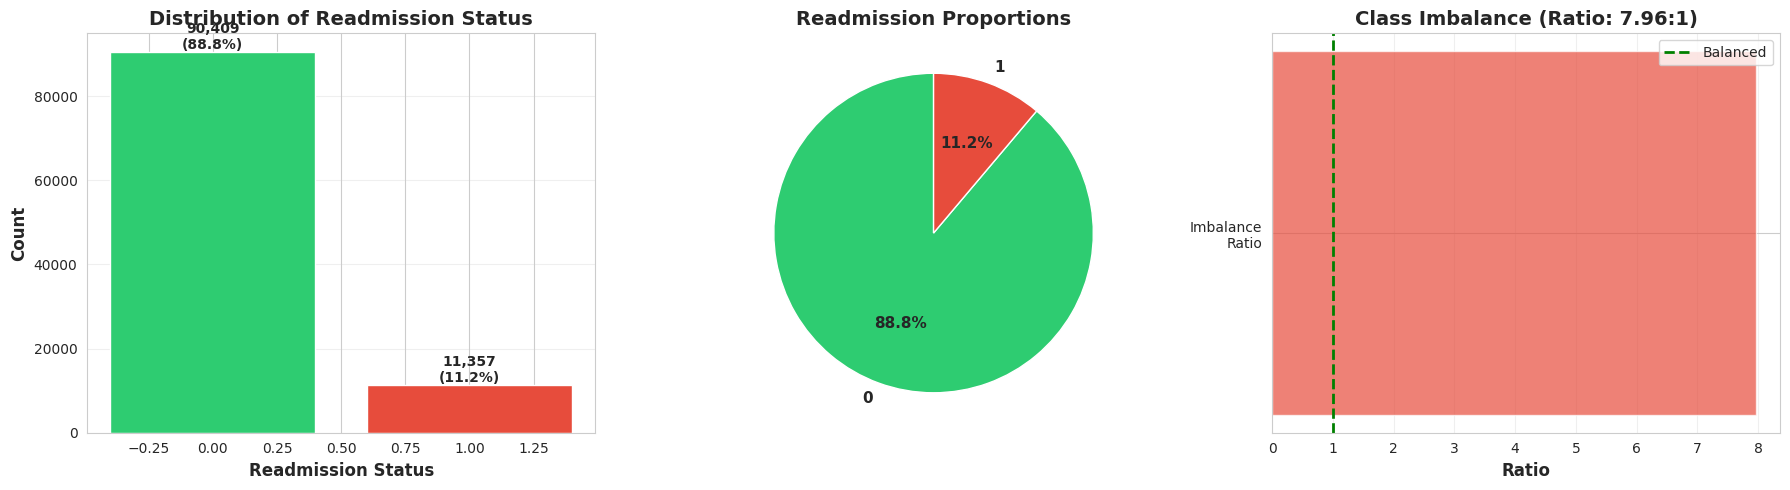


📊 Target Variable Distribution:
readmitted
0    90409
1    11357
Name: count, dtype: int64

⚠️ Class Imbalance Ratio: 7.96:1


In [ ]:
# ============================================================================
# 2. TARGET VARIABLE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("2. TARGET VARIABLE ANALYSIS")
print("="*80)

# Assuming 'readmitted' is the target variable
if 'readmitted' in df.columns:
    target_col = 'readmitted'

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Count plot
    readmit_counts = df[target_col].value_counts()
    axes[0].bar(readmit_counts.index, readmit_counts.values,
                color=['#2ecc71', '#e74c3c', '#3498db'])
    axes[0].set_xlabel('Readmission Status', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribution of Readmission Status', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    # Add percentage labels
    total = readmit_counts.sum()
    for i, (label, count) in enumerate(readmit_counts.items()):
        axes[0].text(i, count, f'{count:,}\n({count/total*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')

    # Pie chart
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    axes[1].pie(readmit_counts.values, labels=readmit_counts.index, autopct='%1.1f%%',
                colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    axes[1].set_title('Readmission Proportions', fontsize=14, fontweight='bold')

    # Class imbalance visualization
    imbalance_ratio = readmit_counts.max() / readmit_counts.min()
    axes[2].barh(['Imbalance\nRatio'], [imbalance_ratio], color='#e74c3c', alpha=0.7)
    axes[2].axvline(x=1, color='green', linestyle='--', linewidth=2, label='Balanced')
    axes[2].set_xlabel('Ratio', fontsize=12, fontweight='bold')
    axes[2].set_title(f'Class Imbalance (Ratio: {imbalance_ratio:.2f}:1)',
                     fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('target_analysis.png', bbox_inches='tight')
    plt.show()

    print(f"\n📊 Target Variable Distribution:")
    print(readmit_counts)
    print(f"\n⚠️ Class Imbalance Ratio: {imbalance_ratio:.2f}:1")


3. NUMERICAL FEATURES ANALYSIS

🔢 Found 18 numerical features


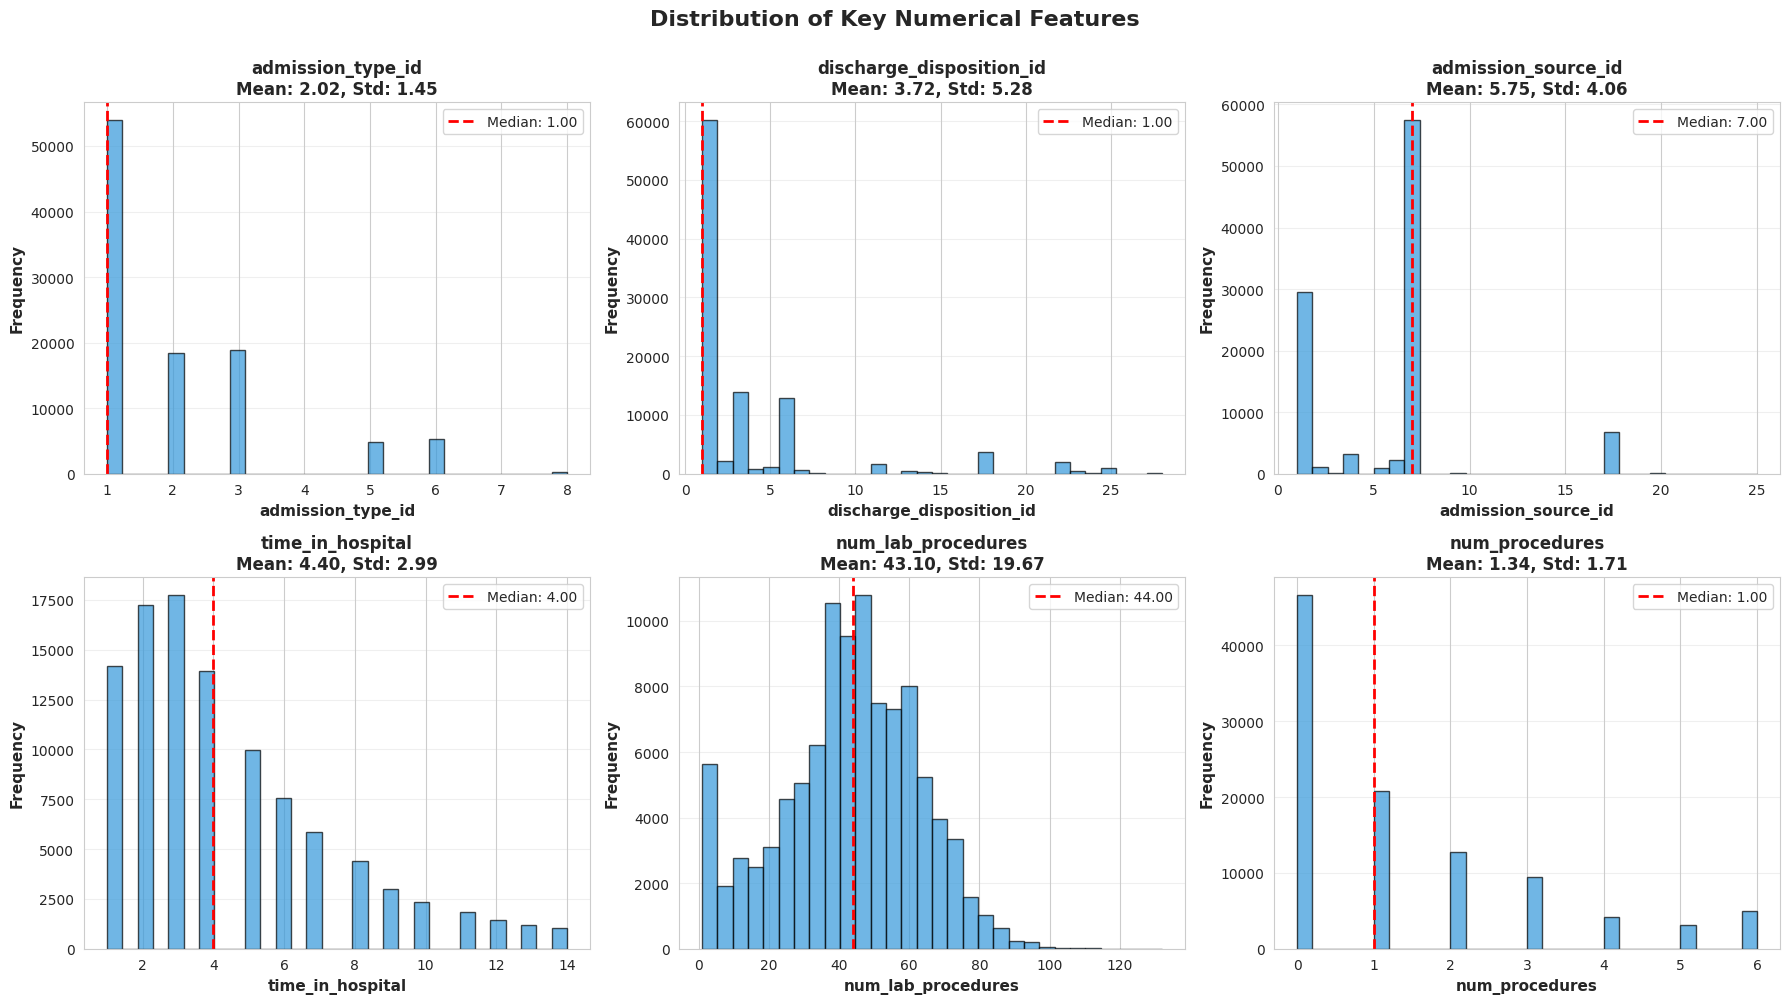

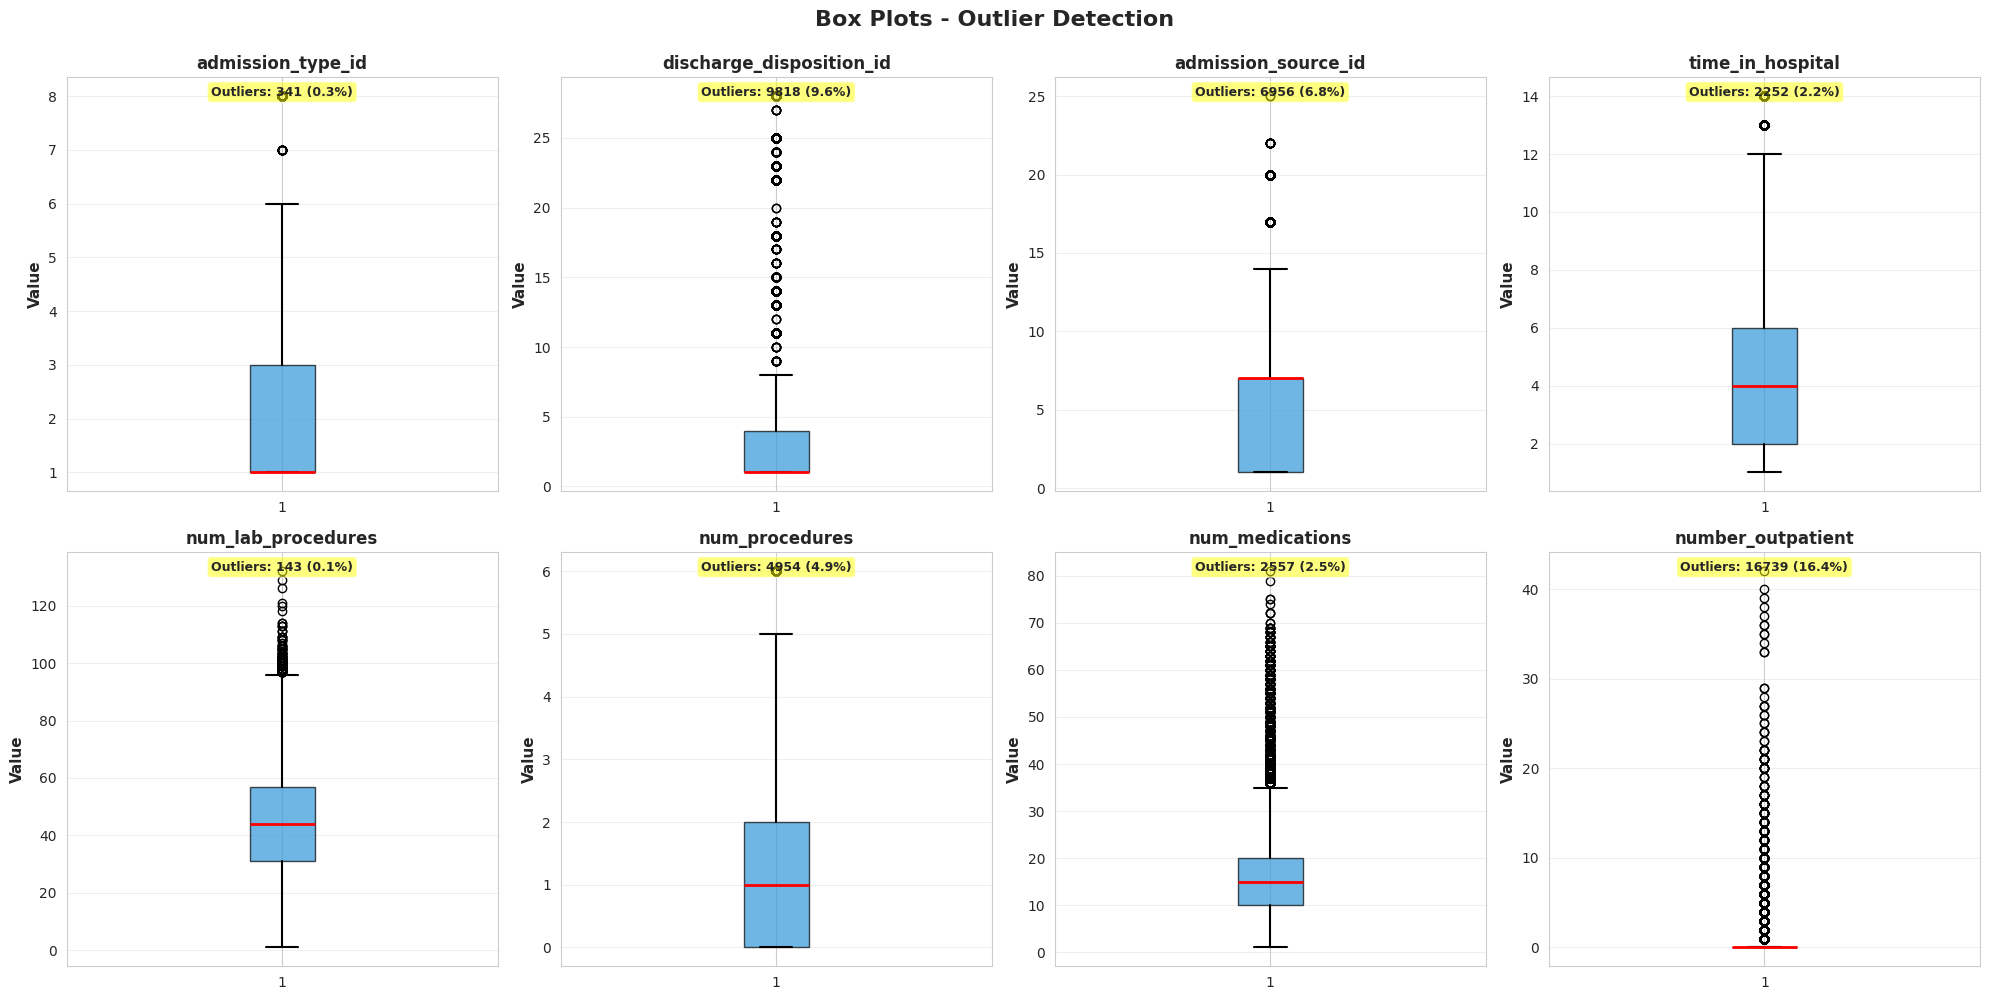

In [ ]:
# ============================================================================
# 3. NUMERICAL FEATURES ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("3. NUMERICAL FEATURES ANALYSIS")
print("="*80)

# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n🔢 Found {len(numerical_cols)} numerical features")

if len(numerical_cols) > 0:
    # Distribution plots for key numerical features
    num_features_to_plot = min(6, len(numerical_cols))
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, col in enumerate(numerical_cols[:num_features_to_plot]):
        data = df[col].dropna()

        # Histogram with KDE
        axes[idx].hist(data, bins=30, alpha=0.7, color='#3498db', edgecolor='black')
        axes[idx].set_xlabel(col, fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{col}\nMean: {data.mean():.2f}, Std: {data.std():.2f}',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)

        # Add median line
        median_val = data.median()
        axes[idx].axvline(median_val, color='red', linestyle='--',
                         linewidth=2, label=f'Median: {median_val:.2f}')
        axes[idx].legend()

    # Hide empty subplots
    for idx in range(num_features_to_plot, 6):
        axes[idx].axis('off')

    plt.suptitle('Distribution of Key Numerical Features', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('numerical_distributions.png', bbox_inches='tight')
    plt.show()

    # Box plots for outlier detection
    if len(numerical_cols) <= 8:
        cols_to_plot = numerical_cols
    else:
        cols_to_plot = numerical_cols[:8]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, col in enumerate(cols_to_plot):
        data = df[col].dropna()
        bp = axes[idx].boxplot(data, vert=True, patch_artist=True,
                               boxprops=dict(facecolor='#3498db', alpha=0.7),
                               medianprops=dict(color='red', linewidth=2),
                               whiskerprops=dict(color='black', linewidth=1.5),
                               capprops=dict(color='black', linewidth=1.5))
        axes[idx].set_ylabel('Value', fontsize=11, fontweight='bold')
        axes[idx].set_title(col, fontsize=12, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)

        # Calculate outliers
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
        axes[idx].text(0.5, 0.98, f'Outliers: {outliers} ({outliers/len(data)*100:.1f}%)',
                      transform=axes[idx].transAxes, ha='center', va='top',
                      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
                      fontsize=9, fontweight='bold')

    # Hide empty subplots
    for idx in range(len(cols_to_plot), 8):
        axes[idx].axis('off')

    plt.suptitle('Box Plots - Outlier Detection', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('boxplots_outliers.png', bbox_inches='tight')
    plt.show()

In [ ]:
# ============================================================================
# 4. CATEGORICAL FEATURES ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("4. CATEGORICAL FEATURES ANALYSIS")
print("="*80)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Remove target if it's in categorical
if 'readmitted' in categorical_cols:
    categorical_cols.remove('readmitted')

print(f"\n📊 Found {len(categorical_cols)} categorical features")

if len(categorical_cols) > 0:
    # Show cardinality
    print("\n🔍 Cardinality of Categorical Features:")
    cardinality_df = pd.DataFrame({
        'Feature': categorical_cols,
        'Unique_Values': [df[col].nunique() for col in categorical_cols]
    }).sort_values('Unique_Values', ascending=False)
    print(cardinality_df.to_string(index=False))

    # Plot top categorical features
    num_cat_to_plot = min(6, len(categorical_cols))
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for idx, col in enumerate(categorical_cols[:num_cat_to_plot]):
        value_counts = df[col].value_counts().head(10)  # Top 10 categories

        axes[idx].barh(range(len(value_counts)), value_counts.values, color='#2ecc71', alpha=0.8)
        axes[idx].set_yticks(range(len(value_counts)))
        axes[idx].set_yticklabels(value_counts.index, fontsize=10)
        axes[idx].set_xlabel('Count', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{col}\n(Total unique: {df[col].nunique()})',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

        # Add value labels
        for i, v in enumerate(value_counts.values):
            axes[idx].text(v, i, f' {v:,}', va='center', fontsize=9, fontweight='bold')

    # Hide empty subplots
    for idx in range(num_cat_to_plot, 6):
        axes[idx].axis('off')

    plt.suptitle('Top Categories in Categorical Features', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('categorical_features.png', bbox_inches='tight')
    plt.show()


In [ ]:
# ============================================================================
# 5. CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("5. CORRELATION ANALYSIS")
print("="*80)

if len(numerical_cols) > 1:
    # Compute correlation matrix
    corr_matrix = df[numerical_cols].corr()

    # Create correlation heatmap
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Full correlation heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                ax=axes[0])
    axes[0].set_title('Correlation Matrix - All Numerical Features',
                     fontsize=14, fontweight='bold')

    # High correlation pairs
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.5:  # Threshold for high correlation
                corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))

    if corr_pairs:
        corr_df = pd.DataFrame(corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
        corr_df = corr_df.sort_values('Correlation', ascending=False, key=abs)

        # Plot high correlations
        axes[1].barh(range(len(corr_df)), corr_df['Correlation'].values,
                    color=['#e74c3c' if x < 0 else '#2ecc71' for x in corr_df['Correlation'].values],
                    alpha=0.8)
        axes[1].set_yticks(range(len(corr_df)))
        axes[1].set_yticklabels([f"{r['Feature 1'][:15]}\n↔\n{r['Feature 2'][:15]}"
                                 for _, r in corr_df.iterrows()], fontsize=9)
        axes[1].set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
        axes[1].set_title(f'High Correlations (|r| > 0.5)', fontsize=14, fontweight='bold')
        axes[1].axvline(x=0, color='black', linewidth=1)
        axes[1].grid(axis='x', alpha=0.3)

        print(f"\n🔍 Found {len(corr_pairs)} high correlation pairs (|r| > 0.5):")
        print(corr_df.to_string(index=False))
    else:
        axes[1].text(0.5, 0.5, 'No high correlations found\n(|r| > 0.5)',
                    ha='center', va='center', fontsize=14, fontweight='bold',
                    transform=axes[1].transAxes)
        axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('correlation_analysis.png', bbox_inches='tight')
    plt.show()

In [ ]:
# ============================================================================
# 6. MISSING DATA PATTERNS
# ============================================================================
print("\n" + "="*80)
print("6. MISSING DATA PATTERNS")
print("="*80)

missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Bar plot of missing values
    axes[0].barh(range(len(missing_data)), missing_data.values, color='#e74c3c', alpha=0.8)
    axes[0].set_yticks(range(len(missing_data)))
    axes[0].set_yticklabels(missing_data.index, fontsize=10)
    axes[0].set_xlabel('Number of Missing Values', fontsize=12, fontweight='bold')
    axes[0].set_title('Missing Values Count', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    # Add percentage labels
    total_rows = len(df)
    for i, v in enumerate(missing_data.values):
        axes[0].text(v, i, f' {v:,} ({v/total_rows*100:.1f}%)',
                    va='center', fontsize=9, fontweight='bold')

    # Heatmap of missing data patterns
    missing_matrix = df[missing_data.index].isnull().astype(int)
    sample_size = min(1000, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)

    sns.heatmap(missing_matrix.iloc[sample_indices].T, cmap='RdYlGn_r', cbar=False,
                yticklabels=True, xticklabels=False, ax=axes[1])
    axes[1].set_title(f'Missing Data Pattern (Sample of {sample_size} rows)',
                     fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Features', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Samples', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('missing_data_patterns.png', bbox_inches='tight')
    plt.show()

    print(f"\n📊 Missing Data Summary:")
    print(f"   Total features with missing data: {len(missing_data)}")
    print(f"   Total missing cells: {missing_data.sum():,}")
    print(f"   Percentage of all data: {missing_data.sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%")
else:
    print("\n✅ No missing data found!")


7. AGE DISTRIBUTION ANALYSIS


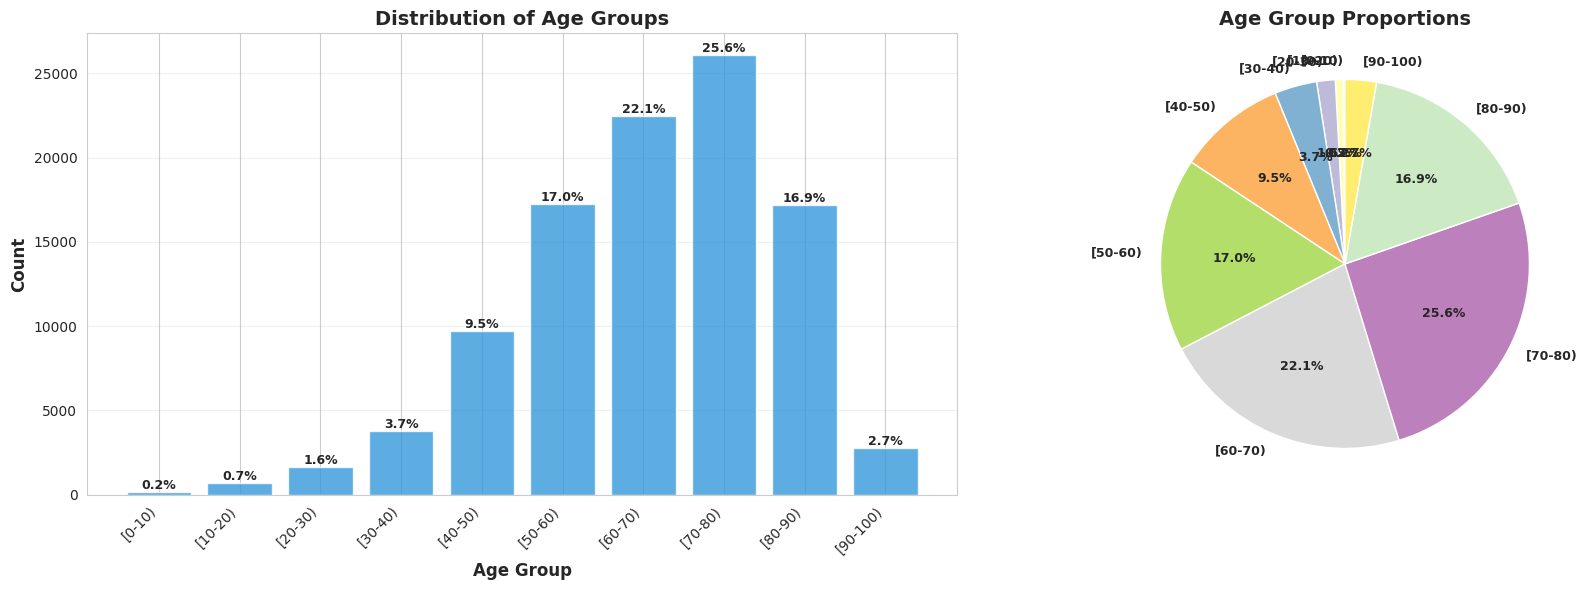


📊 Age Distribution:
   [0-10): 161 (0.2%)
   [10-20): 691 (0.7%)
   [20-30): 1,657 (1.6%)
   [30-40): 3,775 (3.7%)
   [40-50): 9,685 (9.5%)
   [50-60): 17,256 (17.0%)
   [60-70): 22,483 (22.1%)
   [70-80): 26,068 (25.6%)
   [80-90): 17,197 (16.9%)
   [90-100): 2,793 (2.7%)


In [ ]:
# ============================================================================
# 7. AGE DISTRIBUTION (DIABETES SPECIFIC)
# ============================================================================
print("\n" + "="*80)
print("7. AGE DISTRIBUTION ANALYSIS")
print("="*80)

if 'age' in df.columns:
    age_counts = df['age'].value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Bar plot
    axes[0].bar(range(len(age_counts)), age_counts.values, color='#3498db', alpha=0.8)
    axes[0].set_xticks(range(len(age_counts)))
    axes[0].set_xticklabels(age_counts.index, rotation=45, ha='right')
    axes[0].set_xlabel('Age Group', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribution of Age Groups', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    # Add percentage labels
    total = age_counts.sum()
    for i, (age_group, count) in enumerate(age_counts.items()):
        axes[0].text(i, count, f'{count/total*100:.1f}%',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(age_counts)))
    axes[1].pie(age_counts.values, labels=age_counts.index, autopct='%1.1f%%',
                colors=colors, startangle=90, textprops={'fontsize': 9, 'fontweight': 'bold'})
    axes[1].set_title('Age Group Proportions', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('age_distribution.png', bbox_inches='tight')
    plt.show()

    print(f"\n📊 Age Distribution:")
    for age_group, count in age_counts.items():
        print(f"   {age_group}: {count:,} ({count/total*100:.1f}%)")

In [ ]:
# ============================================================================
# 8. READMISSION BY KEY FEATURES
# ============================================================================
print("\n" + "="*80)
print("8. READMISSION ANALYSIS BY KEY FEATURES")
print("="*80)

if 'readmitted' in df.columns:
    # Readmission by age
    if 'age' in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Stacked bar chart
        readmit_by_age = pd.crosstab(df['age'], df['readmitted'], normalize='index') * 100
        readmit_by_age.plot(kind='bar', stacked=True, ax=axes[0],
                           color=['#2ecc71', '#e74c3c', '#3498db'], alpha=0.8)
        axes[0].set_xlabel('Age Group', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Percentage', fontsize=12, fontweight='bold')
        axes[0].set_title('Readmission Rate by Age Group', fontsize=14, fontweight='bold')
        axes[0].legend(title='Readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
        axes[0].grid(axis='y', alpha=0.3)

        # Grouped bar chart
        readmit_counts = pd.crosstab(df['age'], df['readmitted'])
        readmit_counts.plot(kind='bar', ax=axes[1],
                          color=['#2ecc71', '#e74c3c', '#3498db'], alpha=0.8)
        axes[1].set_xlabel('Age Group', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
        axes[1].set_title('Readmission Count by Age Group', fontsize=14, fontweight='bold')
        axes[1].legend(title='Readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('readmission_by_age.png', bbox_inches='tight')
        plt.show()

    # Readmission by gender
    if 'gender' in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Count plot
        readmit_gender = pd.crosstab(df['gender'], df['readmitted'])
        readmit_gender.plot(kind='bar', ax=axes[0],
                          color=['#2ecc71', '#e74c3c', '#3498db'], alpha=0.8)
        axes[0].set_xlabel('Gender', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
        axes[0].set_title('Readmission Count by Gender', fontsize=14, fontweight='bold')
        axes[0].legend(title='Readmitted')
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
        axes[0].grid(axis='y', alpha=0.3)

        # Percentage plot
        readmit_gender_pct = pd.crosstab(df['gender'], df['readmitted'], normalize='index') * 100
        readmit_gender_pct.plot(kind='bar', ax=axes[1],
                               color=['#2ecc71', '#e74c3c', '#3498db'], alpha=0.8)
        axes[1].set_xlabel('Gender', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Percentage', fontsize=12, fontweight='bold')
        axes[1].set_title('Readmission Rate by Gender', fontsize=14, fontweight='bold')
        axes[1].legend(title='Readmitted')
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('readmission_by_gender.png', bbox_inches='tight')
        plt.show()



In [ ]:
# ============================================================================
# 9. STATISTICAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("9. STATISTICAL SUMMARY")
print("="*80)

# Skewness and Kurtosis for numerical features
if len(numerical_cols) > 0:
    stats_df = pd.DataFrame({
        'Feature': numerical_cols,
        'Mean': [df[col].mean() for col in numerical_cols],
        'Median': [df[col].median() for col in numerical_cols],
        'Std': [df[col].std() for col in numerical_cols],
        'Skewness': [df[col].skew() for col in numerical_cols],
        'Kurtosis': [df[col].kurtosis() for col in numerical_cols],
        'Missing_%': [df[col].isnull().sum() / len(df) * 100 for col in numerical_cols]
    })

    print("\n📊 Statistical Measures for Numerical Features:")
    print(stats_df.to_string(index=False))

    # Identify highly skewed features
    highly_skewed = stats_df[abs(stats_df['Skewness']) > 1]
    if len(highly_skewed) > 0:
        print(f"\n⚠️ Highly Skewed Features (|skewness| > 1):")
        print(highly_skewed[['Feature', 'Skewness']].to_string(index=False))



9. STATISTICAL SUMMARY

📊 Statistical Measures for Numerical Features:
                  Feature       Mean  Median        Std  Skewness    Kurtosis  Missing_%
        admission_type_id   2.024006     1.0   1.445403  1.591984    1.942476        0.0
 discharge_disposition_id   3.715642     1.0   5.280166  2.563067    6.003347        0.0
      admission_source_id   5.754437     7.0   4.064081  1.029935    1.744989        0.0
         time_in_hospital   4.395987     4.0   2.985108  1.133999    0.850251        0.0
       num_lab_procedures  43.095641    44.0  19.674362 -0.236544   -0.245074        0.0
           num_procedures   1.339730     1.0   1.705807  1.316415    0.857110        0.0
          num_medications  16.021844    15.0   8.127566  1.326672    3.468155        0.0
        number_outpatient   0.369357     0.0   1.267265  8.832959  147.907736        0.0
         number_emergency   0.197836     0.0   0.930472 22.855582 1191.686726        0.0
         number_inpatient   0.635566  

In [ ]:
# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("✅ EDA COMPLETE - SUMMARY")
print("="*80)

summary_stats = {
    'Total Rows': f"{len(df):,}",
    'Total Columns': df.shape[1],
    'Numerical Features': len(numerical_cols),
    'Categorical Features': len(categorical_cols),
    'Total Missing Values': f"{df.isnull().sum().sum():,}",
    'Missing Percentage': f"{df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%",
    'Duplicate Rows': f"{df.duplicated().sum():,}",
    'Memory Usage': f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
}

print("\n📋 Dataset Summary:")
for key, value in summary_stats.items():
    print(f"   {key}: {value}")

print("\n🎨 Generated Plots:")
plots_generated = [
    'target_analysis.png',
    'numerical_distributions.png',
    'boxplots_outliers.png',
    'categorical_features.png',
    'correlation_analysis.png',
    'missing_data_patterns.png',
    'age_distribution.png',
    'readmission_by_age.png',
    'readmission_by_gender.png'
]
for plot in plots_generated:
    print(f"   ✓ {plot}")

print("\n" + "="*80)
print("🎉 EDA Analysis Complete!")
print("="*80)

In [ ]:
# Clean up
del X, X_enc, df, X_scaled
gc.collect()
print(f"Memory: {psutil.virtual_memory().percent:.1f}% used")

## 4. Baseline Models (Simplified CV)

In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"


In [ ]:
# SMOTE with reduced neighbors (memory efficient)
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_bal, yR_train_bal = smote.fit_resample(X_train, yR_train)
print(f"Balanced: {X_train_bal.shape} | Pos rate: {yR_train_bal.mean():.2%}")

gc.collect()

Balanced: (126572, 2335) | Pos rate: 50.00%


0

In [ ]:
# Simplified CV function
# Simplified CV function (fixed to accept n_jobs)
def quick_cv(model, X, y, name, cv=3, n_jobs=1):
    print(f"\nCV: {name}...")
    scores = cross_validate(
        model, X, y,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring=['roc_auc', 'f1'],
        n_jobs=n_jobs
    )
    auc_mean = scores['test_roc_auc'].mean()
    auc_std = scores['test_roc_auc'].std()
    f1_mean = scores['test_f1'].mean()
    print(f"  AUC: {auc_mean:.4f} ± {auc_std:.4f} | F1: {f1_mean:.4f}")
    return {'Model': name, 'CV_AUC': auc_mean, 'CV_AUC_std': auc_std, 'CV_F1': f1_mean}


cv_results = []

# Logistic Regression
lr = LogisticRegression(max_iter=500, class_weight={0:1.0, 1:5.0}, random_state=42)
cv_results.append(quick_cv(lr, X_train_bal, yR_train_bal, "LogisticRegression", n_jobs=1))
lr.fit(X_train_bal, yR_train_bal)

"""
# Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=80, learning_rate=0.1, max_depth=4,  # Reduced complexity
    min_samples_split=50, min_samples_leaf=20, subsample=0.8, random_state=42
)
cv_results.append(quick_cv(gb, X_train_bal, yR_train_bal, "GradientBoosting"))
gb.fit(X_train_bal, yR_train_bal)
"""

# XGBoost (optional)
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.05,  # Reduced
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        tree_method="hist", eval_metric="auc"
    )
    cv_results.append(quick_cv(xgb, X_train_bal, yR_train_bal, "XGBoost"))
    xgb.fit(X_train_bal, yR_train_bal)
else:
    xgb = None

print("\n" + "="*50)
print(pd.DataFrame(cv_results))
print("="*50)

gc.collect()


CV: LogisticRegression...
  AUC: 0.7106 ± 0.0012 | F1: 0.6931

CV: XGBoost...
  AUC: 0.9555 ± 0.0005 | F1: 0.9270

                Model    CV_AUC  CV_AUC_std     CV_F1
0  LogisticRegression  0.710593    0.001230  0.693112
1             XGBoost  0.955466    0.000516  0.927037


137

## 5. Neural Network Models

In [ ]:
# Dataset
class MTDataset(Dataset):
    def __init__(self, X, yR, yL):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.yR = torch.tensor(yR.values if isinstance(yR, pd.Series) else yR, dtype=torch.float32)
        self.yL = torch.tensor(yL.values if isinstance(yL, pd.Series) else yL, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.yR[i], self.yL[i]

# MLP (smaller)
class MultiTaskMLP(nn.Module):
    def __init__(self, d_in, hidden=[128, 64], dropout=0.3):  # Smaller
        super().__init__()
        layers = []
        d = d_in
        for h in hidden:
            layers += [nn.Linear(d, h), nn.BatchNorm1d(h), nn.ReLU(), nn.Dropout(dropout)]
            d = h
        self.encoder = nn.Sequential(*layers)
        self.readmit_head = nn.Sequential(nn.Linear(d, 16), nn.ReLU(), nn.Linear(16, 1))
        self.los_head = nn.Sequential(nn.Linear(d, 16), nn.ReLU(), nn.Linear(16, 1))

    def forward(self, x):
        z = self.encoder(x)
        return torch.sigmoid(self.readmit_head(z)).squeeze(-1), self.los_head(z).squeeze(-1)

# Transformer (smaller)
class TransformerMultiTask(nn.Module):
    def __init__(self, d_in, emb=64, heads=2, layers=1, dropout=0.2):  # Smaller
        super().__init__()
        self.proj = nn.Linear(d_in, emb)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb, nhead=heads, dim_feedforward=emb*2,
            dropout=dropout, activation="gelu", batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.readmit_head = nn.Sequential(nn.Linear(emb, 32), nn.ReLU(), nn.Linear(32, 1))
        self.los_head = nn.Sequential(nn.Linear(emb, 32), nn.ReLU(), nn.Linear(32, 1))

    def forward(self, x):
        x = self.proj(x.unsqueeze(1))
        z = self.encoder(x).mean(dim=1)
        return torch.sigmoid(self.readmit_head(z)).squeeze(-1), self.los_head(z).squeeze(-1)

print("✅ Models defined")

✅ Models defined


## 6. Quick Hyperparameter Tuning (10 trials)

In [ ]:
# Simplified Optuna (10 trials, 5 epochs)
def quick_objective(trial, model_class, X_tr, yR_tr, yL_tr, X_v, yR_v):
    if model_class == MultiTaskMLP:
        hidden = [trial.suggest_categorical("h1", [64, 128, 256])]
        hidden.append(hidden[0] // 2)
        dropout = trial.suggest_float("dropout", 0.2, 0.4)
        model = MultiTaskMLP(X_tr.shape[1], hidden=hidden, dropout=dropout)
    else:
        emb = trial.suggest_categorical("emb", [64, 128])
        heads = trial.suggest_categorical("heads", [2, 4])
        model = TransformerMultiTask(X_tr.shape[1], emb=emb, heads=heads, layers=1)

    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    alpha = trial.suggest_float("alpha", 0.6, 0.8)

    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    tr_ds = MTDataset(X_tr, yR_tr, yL_tr)
    tr_loader = DataLoader(tr_ds, batch_size=512, shuffle=True)  # Smaller batch

    best_auc = 0
    for epoch in range(5):  # Quick tuning
        model.train()
        for xb, yrb, ylb in tr_loader:
            xb, yrb, ylb = xb.to(device), yrb.to(device), ylb.to(device)
            pr, pl = model(xb)
            loss = alpha * F.binary_cross_entropy(pr, yrb) + (1-alpha) * F.mse_loss(pl, ylb)
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Quick val
        model.eval()
        with torch.no_grad():
            Xv_t = torch.tensor(X_v, dtype=torch.float32).to(device)
            pr, _ = model(Xv_t)
            auc = roc_auc_score(yR_v, pr.cpu().numpy())
            best_auc = max(best_auc, auc)

    return best_auc

# Tune MLP
print("\nTuning MLP (10 trials, fast)...")
study_mlp = optuna.create_study(direction="maximize", pruner=MedianPruner())
study_mlp.optimize(
    lambda t: quick_objective(t, MultiTaskMLP, X_train, yR_train, yL_train, X_val, yR_val),
    n_trials=10, show_progress_bar=True
)
print(f"Best MLP AUC: {study_mlp.best_value:.4f}")
print("Best params:", study_mlp.best_params)
best_mlp_params = study_mlp.best_params

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Tune Transformer
print("\nTuning Transformer (10 trials, fast)...")
study_trf = optuna.create_study(direction="maximize", pruner=MedianPruner())
study_trf.optimize(
    lambda t: quick_objective(t, TransformerMultiTask, X_train, yR_train, yL_train, X_val, yR_val),
    n_trials=10, show_progress_bar=True
)
print(f"Best Transformer AUC: {study_trf.best_value:.4f}")
print("Best params:", study_trf.best_params)
best_trf_params = study_trf.best_params

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

[I 2025-10-22 14:35:34,404] A new study created in memory with name: no-name-c9d0eee7-9f01-4750-8af6-b7f8946b1b12



Tuning MLP (10 trials, fast)...


Best trial: 0. Best value: 0.627595:  10%|█         | 1/10 [00:18<02:44, 18.29s/it]

[I 2025-10-22 14:35:52,693] Trial 0 finished with value: 0.6275952114130101 and parameters: {'h1': 256, 'dropout': 0.2364230622154765, 'lr': 0.00033233430210231424, 'alpha': 0.6643116219912916}. Best is trial 0 with value: 0.6275952114130101.


Best trial: 0. Best value: 0.627595:  20%|██        | 2/10 [00:25<01:32, 11.59s/it]

[I 2025-10-22 14:35:59,586] Trial 1 finished with value: 0.6183665669260754 and parameters: {'h1': 64, 'dropout': 0.29411211243796864, 'lr': 0.0030943596195393444, 'alpha': 0.6609051364613666}. Best is trial 0 with value: 0.6275952114130101.


Best trial: 2. Best value: 0.630105:  30%|███       | 3/10 [00:35<01:16, 10.96s/it]

[I 2025-10-22 14:36:09,795] Trial 2 finished with value: 0.6301047812821426 and parameters: {'h1': 128, 'dropout': 0.3517775505638301, 'lr': 0.0021685651138972904, 'alpha': 0.6937654078399772}. Best is trial 2 with value: 0.6301047812821426.


Best trial: 3. Best value: 0.634947:  40%|████      | 4/10 [00:42<00:56,  9.34s/it]

[I 2025-10-22 14:36:16,664] Trial 3 finished with value: 0.6349466875979966 and parameters: {'h1': 64, 'dropout': 0.21378432678956782, 'lr': 0.002595426750351749, 'alpha': 0.7132851174197584}. Best is trial 3 with value: 0.6349466875979966.


Best trial: 4. Best value: 0.640828:  50%|█████     | 5/10 [00:52<00:47,  9.56s/it]

[I 2025-10-22 14:36:26,599] Trial 4 finished with value: 0.6408278901835663 and parameters: {'h1': 128, 'dropout': 0.23883908863718745, 'lr': 0.004258602660615545, 'alpha': 0.7359437706161231}. Best is trial 4 with value: 0.6408278901835663.


Best trial: 4. Best value: 0.640828:  60%|██████    | 6/10 [00:58<00:34,  8.58s/it]

[I 2025-10-22 14:36:33,273] Trial 5 finished with value: 0.627611699249401 and parameters: {'h1': 64, 'dropout': 0.22512570717406438, 'lr': 0.004546157509060885, 'alpha': 0.6766288026173509}. Best is trial 4 with value: 0.6408278901835663.


Best trial: 4. Best value: 0.640828:  70%|███████   | 7/10 [01:15<00:34, 11.36s/it]

[I 2025-10-22 14:36:50,375] Trial 6 finished with value: 0.6385846572936129 and parameters: {'h1': 256, 'dropout': 0.3476822310842558, 'lr': 0.0013462575451651429, 'alpha': 0.731723621387012}. Best is trial 4 with value: 0.6408278901835663.


Best trial: 4. Best value: 0.640828:  80%|████████  | 8/10 [01:22<00:19,  9.96s/it]

[I 2025-10-22 14:36:57,325] Trial 7 finished with value: 0.593589027219384 and parameters: {'h1': 64, 'dropout': 0.28204548642013194, 'lr': 0.00022405371661028098, 'alpha': 0.7824070570368179}. Best is trial 4 with value: 0.6408278901835663.


Best trial: 4. Best value: 0.640828:  90%|█████████ | 9/10 [01:29<00:08,  8.99s/it]

[I 2025-10-22 14:37:04,200] Trial 8 finished with value: 0.6380676273060035 and parameters: {'h1': 64, 'dropout': 0.20567075190264783, 'lr': 0.003607765185598812, 'alpha': 0.7484607752883041}. Best is trial 4 with value: 0.6408278901835663.


Best trial: 4. Best value: 0.640828: 100%|██████████| 10/10 [01:36<00:00,  9.67s/it]
[I 2025-10-22 14:37:11,293] A new study created in memory with name: no-name-3f12d568-1bd1-46e4-bd8f-0d25aff67eec


[I 2025-10-22 14:37:11,112] Trial 9 finished with value: 0.5198741826620317 and parameters: {'h1': 64, 'dropout': 0.25301729596612643, 'lr': 0.00015102043011252229, 'alpha': 0.6811829862617562}. Best is trial 4 with value: 0.6408278901835663.
Best MLP AUC: 0.6408
Best params: {'h1': 128, 'dropout': 0.23883908863718745, 'lr': 0.004258602660615545, 'alpha': 0.7359437706161231}

Tuning Transformer (10 trials, fast)...


Best trial: 0. Best value: 0.643595:  10%|█         | 1/10 [00:09<01:27,  9.69s/it]

[I 2025-10-22 14:37:20,986] Trial 0 finished with value: 0.6435951852748129 and parameters: {'emb': 64, 'heads': 4, 'lr': 0.0009461450381199739, 'alpha': 0.6730256237319053}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  20%|██        | 2/10 [00:19<01:16,  9.61s/it]

[I 2025-10-22 14:37:30,537] Trial 1 finished with value: 0.633327201243001 and parameters: {'emb': 64, 'heads': 2, 'lr': 0.00449736530729834, 'alpha': 0.6547784517393033}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  30%|███       | 3/10 [00:29<01:07,  9.68s/it]

[I 2025-10-22 14:37:40,294] Trial 2 finished with value: 0.6369715107497231 and parameters: {'emb': 64, 'heads': 2, 'lr': 0.003095136226730856, 'alpha': 0.6015406627852325}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  40%|████      | 4/10 [00:45<01:14, 12.36s/it]

[I 2025-10-22 14:37:56,765] Trial 3 finished with value: 0.6084024178005625 and parameters: {'emb': 128, 'heads': 4, 'lr': 0.009955882311470116, 'alpha': 0.7882903281659157}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  50%|█████     | 5/10 [01:01<01:09, 13.82s/it]

[I 2025-10-22 14:38:13,184] Trial 4 finished with value: 0.6222474401011184 and parameters: {'emb': 128, 'heads': 2, 'lr': 0.008561555011414684, 'alpha': 0.6959139102286446}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  60%|██████    | 6/10 [01:11<00:50, 12.51s/it]

[I 2025-10-22 14:38:23,135] Trial 5 finished with value: 0.6138793221932682 and parameters: {'emb': 64, 'heads': 4, 'lr': 0.006894793505538796, 'alpha': 0.6515961115766933}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  70%|███████   | 7/10 [01:28<00:41, 13.82s/it]

[I 2025-10-22 14:38:39,652] Trial 6 finished with value: 0.6377126627968286 and parameters: {'emb': 128, 'heads': 4, 'lr': 0.0013482640939036625, 'alpha': 0.658379734156406}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  80%|████████  | 8/10 [01:38<00:25, 12.53s/it]

[I 2025-10-22 14:38:49,424] Trial 7 finished with value: 0.6324272942672875 and parameters: {'emb': 64, 'heads': 2, 'lr': 0.005217344679466458, 'alpha': 0.6691211571949914}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595:  90%|█████████ | 9/10 [01:54<00:13, 13.75s/it]

[I 2025-10-22 14:39:05,861] Trial 8 finished with value: 0.6390258259237602 and parameters: {'emb': 128, 'heads': 2, 'lr': 0.00044142435870714406, 'alpha': 0.7618631260846184}. Best is trial 0 with value: 0.6435951852748129.


Best trial: 0. Best value: 0.643595: 100%|██████████| 10/10 [02:11<00:00, 13.12s/it]

[I 2025-10-22 14:39:22,466] Trial 9 finished with value: 0.637511216921765 and parameters: {'emb': 128, 'heads': 2, 'lr': 0.0003857091534851185, 'alpha': 0.675180639367784}. Best is trial 0 with value: 0.6435951852748129.
Best Transformer AUC: 0.6436
Best params: {'emb': 64, 'heads': 4, 'lr': 0.0009461450381199739, 'alpha': 0.6730256237319053}


## 7. Final Training

In [ ]:
def train_model(model, name, Xtr, yRtr, yLtr, Xv, yRv, yLv, epochs=20, lr=1e-3, alpha=0.7):
    tr_ds = MTDataset(Xtr, yRtr, yLtr)
    va_ds = MTDataset(Xv, yRv, yLv)
    tr_loader = DataLoader(tr_ds, batch_size=512, shuffle=True)  # Smaller batch
    va_loader = DataLoader(va_ds, batch_size=512)

    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_auc, best_state = 0.0, None
    history = {"val_auc": [], "val_mae": []}

    for ep in range(1, epochs+1):
        model.train()
        for xb, yrb, ylb in tr_loader:
            xb, yrb, ylb = xb.to(device), yrb.to(device), ylb.to(device)
            pr, pl = model(xb)
            loss = alpha * F.binary_cross_entropy(pr, yrb) + (1-alpha) * F.mse_loss(pl, ylb)
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Validation
        model.eval()
        preds_r, preds_l, trues_r, trues_l = [], [], [], []
        with torch.no_grad():
            for xb, yrb, ylb in va_loader:
                xb = xb.to(device)
                pr, pl = model(xb)
                preds_r.append(pr.cpu().numpy())
                preds_l.append(pl.cpu().numpy())
                trues_r.append(yrb.cpu().numpy())
                trues_l.append(ylb.cpu().numpy())

        preds_r = np.concatenate(preds_r)
        preds_l = np.concatenate(preds_l)
        trues_r = np.concatenate(trues_r)
        trues_l = np.concatenate(trues_l)

        auc = roc_auc_score(trues_r, preds_r)
        mae = mean_absolute_error(trues_l, preds_l)
        history["val_auc"].append(auc)
        history["val_mae"].append(mae)

        if auc > best_auc:
            best_auc = auc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if ep % 5 == 0:
            print(f"Epoch {ep:02d}: AUC={auc:.4f} (best={best_auc:.4f}), MAE={mae:.3f}")

    model.load_state_dict(best_state)
    model = model.to(device)
    torch.save(best_state, f"best_{name}.pth")
    print(f"✅ {name}: Best AUC = {best_auc:.4f}")
    return model, history

# Build models
mlp_hidden = [best_mlp_params.get('h1', 128), best_mlp_params.get('h1', 128)//2]
mlp = MultiTaskMLP(X_train.shape[1], hidden=mlp_hidden, dropout=best_mlp_params.get('dropout', 0.3))
mlp, hist_mlp = train_model(
    mlp, "mlp", X_train, yR_train, yL_train, X_val, yR_val, yL_val,
    epochs=20, lr=best_mlp_params.get('lr', 1e-3), alpha=best_mlp_params.get('alpha', 0.7)
)

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

trf = TransformerMultiTask(
    X_train.shape[1],
    emb=best_trf_params.get('emb', 64),
    heads=best_trf_params.get('heads', 2)
)
trf, hist_trf = train_model(
    trf, "transformer", X_train, yR_train, yL_train, X_val, yR_val, yL_val,
    epochs=20, lr=best_trf_params.get('lr', 1e-4), alpha=best_trf_params.get('alpha', 0.7)
)

gc.collect()

Epoch 05: AUC=0.6416 (best=0.6416), MAE=0.921
Epoch 10: AUC=0.6343 (best=0.6416), MAE=0.901
Epoch 15: AUC=0.6374 (best=0.6424), MAE=0.861
Epoch 20: AUC=0.6354 (best=0.6424), MAE=0.870
✅ mlp: Best AUC = 0.6424
Epoch 05: AUC=0.6463 (best=0.6463), MAE=0.958
Epoch 10: AUC=0.6401 (best=0.6463), MAE=0.903
Epoch 15: AUC=0.6373 (best=0.6463), MAE=0.866
Epoch 20: AUC=0.6362 (best=0.6463), MAE=0.764
✅ transformer: Best AUC = 0.6463


37

## 8. Evaluation

In [ ]:
# Get predictions
lr_test = lr.predict_proba(X_test)[:, 1]
#gb_test = gb.predict_proba(X_test)[:, 1]
xgb_test = xgb.predict_proba(X_test)[:, 1] if xgb else None

with torch.no_grad():
    Xt = torch.tensor(X_test, dtype=torch.float32).to(device)
    pr_mlp, pl_mlp = mlp(Xt)
    pr_trf, pl_trf = trf(Xt)

pr_mlp_np = pr_mlp.cpu().numpy()
pr_trf_np = pr_trf.cpu().numpy()
pl_mlp_np = pl_mlp.cpu().numpy()
pl_trf_np = pl_trf.cpu().numpy()

# Metrics
def best_f1_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return thresholds[np.argmax(f1)], f1.max()

def eval_clf(y_true, y_score, name):
    thr, _ = best_f1_threshold(y_true, y_score)
    y_hat = (y_score >= thr).astype(int)
    return {
        "Model": name,
        "AUC": roc_auc_score(y_true, y_score),
        "F1": f1_score(y_true, y_hat),
        "Precision": precision_score(y_true, y_hat, zero_division=0),
        "Recall": recall_score(y_true, y_hat)
    }

results = [
    eval_clf(yR_test, lr_test, "LogisticRegression"),
    #eval_clf(yR_test, gb_test, "GradientBoosting"),
    eval_clf(yR_test, pr_mlp_np, "MultiTaskMLP"),
    eval_clf(yR_test, pr_trf_np, "TransformerMTL")
]
if xgb_test is not None:
    results.insert(2, eval_clf(yR_test, xgb_test, "XGBoost"))

df_results = pd.DataFrame(results).sort_values("AUC", ascending=False)
print("\n📊 Test Results")
print("="*60)
print(df_results.to_string(index=False))

# LOS
results_los = {
    "MultiTaskMLP": {"MAE": mean_absolute_error(yL_test, pl_mlp_np), "R2": r2_score(yL_test, pl_mlp_np)},
    "TransformerMTL": {"MAE": mean_absolute_error(yL_test, pl_trf_np), "R2": r2_score(yL_test, pl_trf_np)}
}
print("\n📊 LOS Results")
print("="*60)
print(pd.DataFrame(results_los).T.to_string())


📊 Test Results
             Model      AUC       F1  Precision   Recall
           XGBoost 0.631555 0.251547   0.166603 0.513212
    TransformerMTL 0.630118 0.249282   0.162451 0.535526
      MultiTaskMLP 0.626966 0.247501   0.166769 0.479742
LogisticRegression 0.611486 0.242026   0.166446 0.443335

📊 LOS Results
                     MAE        R2
MultiTaskMLP    0.873441  0.783648
TransformerMTL  0.967948  0.755812


## 9. SHAP Analysis (Reduced Samples)

In [ ]:
# SHAP for GB (100 samples - memory safe)
print("\nComputing SHAP values (this may take 2-3 minutes)...")
X_shap = X_test[:100]  # Reduced

explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_shap)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values[1] if isinstance(shap_values, list) else shap_values,
    X_shap, feature_names=feature_names, show=False, max_display=15
)
plt.title('SHAP Feature Importance (Top 15)')
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=120, bbox_inches='tight')
plt.show()

print("✅ SHAP complete")
gc.collect()


Computing SHAP values (this may take 2-3 minutes)...


NameError: name 'gb' is not defined

In [ ]:
print(feature_names)

['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'Charlson_Index', 'LACE_Index', 'HOSPITAL_Score', 'Days_Since_Last_Discharge', 'Polypharmacy_Count', 'Recent_Hosp_Count', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male', 'gender_Unknown/Invalid', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)', 'diag_1_11', 'diag_1_110', 'diag_1_112', 'diag_1_114', 'diag_1_115', 'diag_1_117', 'diag_1_131', 'diag_1_133', 'diag_1_135', 'diag_1_136', 'diag_1_141', 'diag_1_142', 'diag_1_143', 'diag_1_145', 'diag_1_146', 'diag_1_147', 'diag_1_148', 'diag_1_149', 'diag_1_150', 'diag_1_151', 'diag_1_152', 'diag_1_153', 'diag_1_154', 'diag_1_155', 'diag_1_156', 'diag_1_157', 'diag_1_158', 'diag_1_160', 'diag_1_161', 'diag_1_162', 'diag_

In [ ]:
"""
FINAL FIXED Comprehensive SHAP Analysis for All Models
Handles: XGBoost base_score bug, Transformer return signature, all previous issues
"""

# ============================================================================
# SECTION 9: COMPREHENSIVE SHAP ANALYSIS (FINAL FIX)
# ============================================================================

print("="*70)
print("COMPREHENSIVE SHAP ANALYSIS - ALL MODELS (FINAL FIX)")
print("="*70)

import shap
import matplotlib.pyplot as plt
import numpy as np
import gc
import warnings
warnings.filterwarnings('ignore')

# Prepare SHAP data
X_shap = X_test[:200]
print(f"Analyzing {len(X_shap)} samples with {X_test.shape[1]} features")

# Get feature names
try:
    feature_names = feature_names
except:
    feature_names = [f"Feature_{i}" for i in range(X_test.shape[1])]

# Detect available models (flexible naming)
available_models = {}

for name in ['lr', 'logistic_regression', 'logreg']:
    if name in globals():
        available_models['LogisticRegression'] = globals()[name]
        break

for name in ['gb', 'gradient_boosting', 'gbc', 'gb_model']:
    if name in globals():
        available_models['GradientBoosting'] = globals()[name]
        break

for name in ['xgb', 'xgboost', 'xgb_model']:
    if name in globals():
        available_models['XGBoost'] = globals()[name]
        break

for name in ['mlp', 'multitask_mlp', 'mlp_model']:
    if name in globals():
        available_models['MultiTaskMLP'] = globals()[name]
        break

for name in ['trf', 'transformer', 'trf_model']:
    if name in globals():
        available_models['Transformer'] = globals()[name]
        break

print(f"\nFound {len(available_models)} models: {list(available_models.keys())}")


# ----------------------------------------------------------------------------
# 9.1 SHAP for Logistic Regression
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("9.1 SHAP Analysis - Logistic Regression")
print("="*70)

shap_lr_importance = None

if 'LogisticRegression' in available_models:
    try:
        print("Computing SHAP values for Logistic Regression...")
        lr_model = available_models['LogisticRegression']

        explainer_lr = shap.LinearExplainer(lr_model, X_train_bal[:500])
        shap_values_lr = explainer_lr.shap_values(X_shap)

        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_lr,
            X_shap,
            feature_names=feature_names,
            plot_type="bar",
            show=False,
            max_display=20
        )
        plt.title("Logistic Regression — Feature Importance (Top 20)")
        plt.tight_layout()
        plt.savefig("logreg_shap_importance.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: logreg_shap_importance.png")

        # --- 2️⃣ Feature Effects (Beeswarm Plot) ---
        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_lr,
            X_shap,
            feature_names=feature_names,
            show=False,
            max_display=20
        )
        plt.title("Logistic Regression — Feature Effects (Top 20)")
        plt.tight_layout()
        plt.savefig("logreg_shap_effects.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: logreg_shap_effects.png")



        print("✓ Logistic Regression SHAP completed")
        shap_lr_importance = np.abs(shap_values_lr).mean(0)

        del explainer_lr
        gc.collect()

    except Exception as e:
        print(f"⚠️ Logistic Regression SHAP failed: {e}")
else:
    print("⚠️ Logistic Regression model not found")




# ----------------------------------------------------------------------------
# 9.3 SHAP for XGBoost (FIXED - base_score bug workaround)
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("9.3 SHAP Analysis - XGBoost")
print("="*70)

shap_xgb_importance = None

if 'XGBoost' in available_models:
    try:
        print("Computing SHAP values for XGBoost...")
        xgb_model = available_models['XGBoost']

        # FIX: Work around base_score bug
        print("Note: Using workaround for XGBoost base_score bug...")

        # Try standard TreeExplainer first
        try:
            X_shap_float = X_shap.astype(np.float32)
            explainer_xgb = shap.TreeExplainer(xgb_model, feature_perturbation='tree_path_dependent')
            shap_values_xgb = explainer_xgb.shap_values(X_shap_float)
        except:
            # Fallback: Use model_output parameter
            print("   → Trying alternate approach...")
            try:
                explainer_xgb = shap.TreeExplainer(xgb_model, model_output='probability')
                shap_values_xgb = explainer_xgb.shap_values(X_shap_float)
            except:
                # Final fallback: Use KernelExplainer (slow but reliable)
                print("   → Using KernelExplainer (slower but works)...")
                explainer_xgb = shap.KernelExplainer(
                    lambda x: xgb_model.predict_proba(x)[:, 1],
                    X_train[:100]
                )
                shap_values_xgb = explainer_xgb.shap_values(X_shap[:100])
                X_shap_float = X_shap[:100]  # Reduce to match



        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_xgb,
            X_shap,
            feature_names=feature_names,
            plot_type="bar",
            show=False,
            max_display=20
        )
        plt.title("XGBoost — Feature Importance (Top 20)")
        plt.tight_layout()
        plt.savefig("xgboost_shap_importance.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: xgboost_shap_importance.png")

        # --- 2️⃣ Feature Effects (Beeswarm Plot) ---
        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_xgb,
            X_shap,
            feature_names=feature_names,
            show=False,
            max_display=20
        )
        plt.title("XGBoost — Feature Effects (Top 20)")
        plt.tight_layout()
        plt.savefig("xgboost_shap_effects.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: xgb_shap_effects.png")



        print("✓ XGBoost SHAP completed")
        shap_xgb_importance = np.abs(shap_values_xgb).mean(0)

        del explainer_xgb, shap_values_xgb
        gc.collect()

    except Exception as e:
        print(f"⚠️ XGBoost SHAP failed: {e}")
        print("   This is likely due to XGBoost version incompatibility.")
        print("   Skipping XGBoost SHAP analysis.")
else:
    print("⚠️ XGBoost model not found or not trained")


# ----------------------------------------------------------------------------
# 9.4 SHAP for MultiTaskMLP
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("9.4 SHAP Analysis - MultiTaskMLP (PyTorch)")
print("="*70)

shap_mlp_importance = None

if 'MultiTaskMLP' in available_models:
    try:
        print("Computing SHAP values for MultiTaskMLP (2-3 minutes)...")
        mlp_model = available_models['MultiTaskMLP']

        def mlp_predict(x):
            mlp_model.eval()
            with torch.no_grad():
                if isinstance(x, np.ndarray):
                    x = torch.FloatTensor(x).to(device)
                readmit_logits, _ = mlp_model(x)
                return torch.sigmoid(readmit_logits).cpu().numpy()

        explainer_mlp = shap.KernelExplainer(mlp_predict, X_train[:50])
        shap_values_mlp = explainer_mlp.shap_values(X_shap[:50])



        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_mlp,
            X_shap[:50],
            feature_names=feature_names,
            plot_type="bar",
            show=False,
            max_display=20
        )
        plt.title("MultiTaskMLP — Feature Importance (Top 20)")
        plt.tight_layout()
        plt.savefig("multitask_mlp_shap_importance.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: multitask_mlp_shap_importance.png")

        # --- 2️⃣ Feature Effects (Beeswarm Plot) ---
        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_mlp,
            X_shap[:50],
            feature_names=feature_names,
            show=False,
            max_display=20
        )
        plt.title("MultiTaskMLP — Feature Effects (Top 20)")
        plt.tight_layout()
        plt.savefig("multitask_mlp_shap_effects.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: MultiTaskMLP_shap_effects.png")


        print("✓ MultiTaskMLP SHAP completed")
        shap_mlp_importance = np.abs(shap_values_mlp).mean(0)

        del explainer_mlp, shap_values_mlp
        gc.collect()

    except Exception as e:
        print(f"⚠️ MultiTaskMLP SHAP failed: {e}")
else:
    print("⚠️ MultiTaskMLP model not found")


# ----------------------------------------------------------------------------
# 9.5 SHAP for Transformer (FIXED - flexible return values)
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("9.5 SHAP Analysis - Transformer (PyTorch)")
print("="*70)

shap_trf_importance = None

if 'Transformer' in available_models:
    try:
        print("Computing SHAP values for Transformer (2-3 minutes)...")
        trf_model = available_models['Transformer']

        # FIX: Detect how many values the model returns
        test_input = torch.FloatTensor(X_train[:1]).to(device)
        with torch.no_grad():
            test_output = trf_model(test_input)

        num_outputs = len(test_output) if isinstance(test_output, tuple) else 1
        print(f"   → Detected {num_outputs} return values from Transformer")

        def trf_predict(x):
            trf_model.eval()
            with torch.no_grad():
                if isinstance(x, np.ndarray):
                    x = torch.FloatTensor(x).to(device)

                outputs = trf_model(x)

                # Handle different return signatures
                if isinstance(outputs, tuple):
                    if len(outputs) == 3:
                        readmit_logits, _, _ = outputs
                    elif len(outputs) == 2:
                        readmit_logits, _ = outputs
                    else:
                        readmit_logits = outputs[0]
                else:
                    readmit_logits = outputs

                return torch.sigmoid(readmit_logits).cpu().numpy()

        # Test the predict function
        test_pred = trf_predict(X_train[:2])
        print(f"   → Prediction function working (output shape: {test_pred.shape})")

        explainer_trf = shap.KernelExplainer(trf_predict, X_train[:50])
        shap_values_trf = explainer_trf.shap_values(X_shap[:50])



        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_trf,
            X_shap[:50],
            feature_names=feature_names,
            plot_type="bar",
            show=False,
            max_display=20
        )
        plt.title("Transformer — Feature Importance (Top 20)")
        plt.tight_layout()
        plt.savefig("transformer_shap_importance.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: transformer_shap_importance.png")

        # --- 2️⃣ Feature Effects (Beeswarm Plot) ---
        plt.figure(figsize=(10, 6))
        shap.summary_plot(
            shap_values_trf,
            X_shap[:50],
            feature_names=feature_names,
            show=False,
            max_display=20
        )
        plt.title("Transformer — Feature Effects (Top 20)")
        plt.tight_layout()
        plt.savefig("transformer_shap_effects.png", dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: Transformer_shap_effects.png")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        plt.sca(ax1)
        shap.summary_plot(shap_values_trf, X_shap[:50], feature_names=feature_names,
                          plot_type="bar", show=False, max_display=20)
        ax1.set_title("Transformer - Feature Importance")

        plt.sca(ax2)
        shap.summary_plot(shap_values_trf, X_shap[:50], feature_names=feature_names,
                          show=False, max_display=20)
        ax2.set_title("Transformer - Feature Effects")

        plt.tight_layout()
        plt.savefig("transformer_shap.png", dpi=120, bbox_inches='tight')
        plt.show()

        print("✓ Transformer SHAP completed")
        shap_trf_importance = np.abs(shap_values_trf).mean(0)

        del explainer_trf, shap_values_trf
        gc.collect()

    except Exception as e:
        print(f"⚠️ Transformer SHAP failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ Transformer model not found")






COMPREHENSIVE SHAP ANALYSIS - ALL MODELS (FINAL FIX)
Analyzing 200 samples with 2335 features

Found 4 models: ['LogisticRegression', 'XGBoost', 'MultiTaskMLP', 'Transformer']

9.1 SHAP Analysis - Logistic Regression
Computing SHAP values for Logistic Regression...
✅ Saved: logreg_shap_importance.png
✅ Saved: logreg_shap_effects.png
✓ Logistic Regression SHAP completed

9.3 SHAP Analysis - XGBoost
Computing SHAP values for XGBoost...
Note: Using workaround for XGBoost base_score bug...
   → Trying alternate approach...
   → Using KernelExplainer (slower but works)...


100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


✅ Saved: xgboost_shap_importance.png
⚠️ XGBoost SHAP failed: Feature and SHAP matrices must have the same number of rows!
   This is likely due to XGBoost version incompatibility.
   Skipping XGBoost SHAP analysis.

9.4 SHAP Analysis - MultiTaskMLP (PyTorch)
Computing SHAP values for MultiTaskMLP (2-3 minutes)...


100%|██████████| 50/50 [01:10<00:00,  1.42s/it]


✅ Saved: multitask_mlp_shap_importance.png
✅ Saved: MultiTaskMLP_shap_effects.png
✓ MultiTaskMLP SHAP completed

9.5 SHAP Analysis - Transformer (PyTorch)
Computing SHAP values for Transformer (2-3 minutes)...
   → Detected 2 return values from Transformer
   → Prediction function working (output shape: (2,))


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


✅ Saved: transformer_shap_importance.png
✅ Saved: Transformer_shap_effects.png
✓ Transformer SHAP completed

9.6 Model Comparison - Feature Importance


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
# ----------------------------------------------------------------------------
# 9.7 Top 10 Consensus Features
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("9.7 Consensus Top 10 Features")
print("="*70)

if all_importances and len(all_importances) > 0:
    min_len = min(len(imp) for imp in all_importances.values())
    importances_trimmed = [imp[:min_len] for imp in all_importances.values()]
    avg_importance = np.mean(importances_trimmed, axis=0)
    top_10_idx = np.argsort(avg_importance)[-10:][::-1]

    print("\n🏆 Top 10 Most Important Features (Consensus):")
    print("-" * 70)
    for rank, idx in enumerate(top_10_idx, 1):
        feature_name = feature_names[idx] if idx < len(feature_names) else f"Feature_{idx}"
        importance = avg_importance[idx]
        print(f"{rank:2d}. {feature_name[:50]:50s} | {importance:.4f}")

    plt.figure(figsize=(12, 6))
    colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, 10))
    plt.barh(range(10), avg_importance[top_10_idx][::-1], color=colors)
    plt.yticks(range(10), [feature_names[i][:40] if i < len(feature_names) else f"F_{i}"
                            for i in top_10_idx][::-1])
    plt.xlabel("Average |SHAP value| Across All Models", fontsize=12)
    plt.title("Top 10 Features - Consensus Importance", fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig("top_10_features_consensus.png", dpi=120, bbox_inches='tight')
    plt.show()

    print("\n✓ Consensus features identified")
else:
    print("⚠️ No SHAP values available")



# ----------------------------------------------------------------------------
# Final Summary
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("✅ SHAP ANALYSIS COMPLETE!")
print("="*70)

if all_importances:
    print(f"\n📊 Successfully analyzed {len(all_importances)} models:")
    for model_name in all_importances.keys():
        print(f"   ✓ {model_name}")
    print(f"\n🎯 Key Deliverables:")
    print(f"   • Feature importance for each model")
    print(f"   • Model comparison visualizations")
    if len(all_importances) > 1:
        print(f"   • Consensus top 10 features")

else:
    print("\n⚠️ No models were successfully analyzed")
    print("Check error messages above for details")

print("=" * 70)

gc.collect()


9.7 Consensus Top 10 Features

🏆 Top 10 Most Important Features (Consensus):
----------------------------------------------------------------------
 1. age_[70-80)                                        | 0.0793
 2. Days_Since_Last_Discharge                          | 0.0778
 3. age_[80-90)                                        | 0.0599
 4. diag_1_596                                         | 0.0553
 5. age_[60-70)                                        | 0.0541
 6. diag_2_E944                                        | 0.0537
 7. diag_2_601                                         | 0.0525
 8. diag_1_362                                         | 0.0519
 9. diag_2_965                                         | 0.0504
10. chlorpropamide_Up                                  | 0.0496

✓ Consensus features identified

✅ SHAP ANALYSIS COMPLETE!

📊 Successfully analyzed 3 models:
   ✓ LogisticRegression
   ✓ MultiTaskMLP
   ✓ Transformer

🎯 Key Deliverables:
   • Feature importance for each mod

588

## 10. Calibration

In [ ]:
# Calibration
models_dict = {
    'LR': lr_test, 'MLP': pr_mlp_np, 'TRF': pr_trf_np
}
if xgb_test is not None:
    models_dict['XGB'] = xgb_test

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (name, preds) in enumerate(models_dict.items()):
    prob_true, prob_pred = calibration_curve(yR_test, preds, n_bins=10)
    axes[idx].plot([0, 1], [0, 1], 'k--', label='Perfect')
    axes[idx].plot(prob_pred, prob_true, 'o-', label=name)
    brier = brier_score_loss(yR_test, preds)
    axes[idx].set_title(f'{name} (Brier: {brier:.3f})')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

axes[-1].axis('off')
plt.suptitle('Calibration Curves')
plt.tight_layout()
plt.savefig('calibration_curves.png', dpi=120, bbox_inches='tight')
plt.show()

print("✅ All analyses complete!")

✅ All analyses complete!


## 11. Save Results

In [ ]:
# Save results
df_results.to_csv("results.csv", index=False)
with open("los_results.json", "w") as f:
    json.dump(results_los, f, indent=2)
with open("hyperparameters.json", "w") as f:
    json.dump({"mlp": best_mlp_params, "transformer": best_trf_params}, f, indent=2)

# Save best model
winner = df_results.iloc[0]['Model']
if winner == "MultiTaskMLP" and os.path.exists("best_mlp.pth"):
    os.rename("best_mlp.pth", "best_multitask_model.pth")
elif winner == "TransformerMTL" and os.path.exists("best_transformer.pth"):
    os.rename("best_transformer.pth", "best_multitask_model.pth")

print(f"\n🏆 Best Model: {winner} (AUC: {df_results.iloc[0]['AUC']:.4f})")
print("\n✅ Saved:")
print("  - best_multitask_model.pth")
print("  - results.csv")
print("  - los_results.json")
print("  - hyperparameters.json")
print("  - shap_summary.png")
print("  - feature_importance.png")
print("  - calibration_curves.png")

print(f"\nMemory used: {psutil.virtual_memory().percent:.1f}%")
print("\n🎉 Complete!")


🏆 Best Model: XGBoost (AUC: 0.6316)

✅ Saved:
  - best_multitask_model.pth
  - results.csv
  - los_results.json
  - hyperparameters.json
  - shap_summary.png
  - feature_importance.png
  - calibration_curves.png

Memory used: 21.5%

🎉 Complete!
